## Fungi Image Classification

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob
import cv2
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, cross_validate, ShuffleSplit
from sklearn import preprocessing

import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Activation, Add, MaxPool2D
import keras
#from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam, AdamW
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import Callback
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import learning_curve
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import collections
from sklearn.metrics import classification_report, confusion_matrix

print("Tensorflow Version:", tf.__version__)
print("Keras Version:", keras.__version__)

#project_path = 'Defungi_S'
project_path = 'Defungi'
#project_path = 'Defungi_Preprocessing'
project_seed = 42
project_image_size = (32,32)
#project_image_size = (64,64)
#project_image_size = (128,128)
#project_image_size = (500,500)
project_filter_size = 256
#project_batch_size = 16
project_batch_size = 128
project_epochs = 10
project_folds = 5
#project_split = 0.15   # Optimal split for ResNet
project_split = 0.3   # Optimal split for ConvMixer
#project_learning_rate = 0.001
project_learning_rate = 0.00032
project_auto = tf.data.AUTOTUNE

Tensorflow Version: 2.14.0
Keras Version: 2.14.0


### Preprocessing the Data and Organizing as a csv-file

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def plot_image(image_path):
    cur_img = mpimg.imread(image_path)
    plt.imshow(cur_img)
    plt.show()  # Display the image

In [3]:
def variance_of_filtered_image(image_path, ker_edge_detect, is_im_show = 0):
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    img = cv2.filter2D(src = image_gray.astype("uint8"), ddepth = -1, kernel = ker_edge_detect)
    variance = np.var(img)
    if is_im_show:
        print(variance)
        plot_image(image_path)
        plt.imshow(img)
        plt.show()  # Display the image
    return variance

In [4]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err
    
def compare_images(image_path, ker_edge_detect):
	# compute the mean squared error and structural similarity
	# index for the images
    image  = cv2.imread(image_path)
    imageA = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    imageB = cv2.filter2D(src = imageA.astype("uint8"), ddepth = -1, kernel = ker_edge_detect)
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB)

    vec_arg = np.array([m, s])
    return vec_arg

In [5]:
def image_variance(image_path, is_im_show = 0):
    image  = cv2.imread(image_path)
    mean = np.mean(image)
    variance = np.mean((image - mean) ** 2)
    if is_im_show:
        print(image_path)
        print(variance)
        plot_image(image_path)
    return variance

In [6]:
ker_edge_detect_1 = np.array([[-1, -1, -1], 
                              [-1,  8, -1], 
                              [-1, -1, -1]])
ker_edge_detect_2 = np.array([[ 0, -1,  0], 
                              [-1,  4, -1], 
                              [ 0, -1,  0]])
ker_Sobel_x = np.array([[ -1,  0,  1], 
                        [ -2,  0,  2], 
                        [ -1,  0,  1]])
ker_Sobel_y = np.array([[ -1, -2, -1], 
                        [  0,  0,  0], 
                        [  1,  2,  1]])
ker_Sharpen = np.array([[ 0, -1,  0],
                        [-1,  5, -1],
                        [ 0, -1,  0]])
ker_Blurring = 1/9 *  np.array([[1, 1, 1],
                               [1, 1, 1],
                               [1, 1, 1]])

In [22]:
files = [i for i in glob.glob(project_path + "//*//*")]
#np.random.shuffle(files)

# Taking the 2 symbols between the string 'Defungi\' and the file-name
labels = [os.path.dirname(i).split("/")[-1][-2:] for i in files]
fungus_classes = {'H1':0, 'H2':1, 'H3':2, 'H5':3, 'H6':4}
classes = [fungus_classes[labels[i]] for i in range(len(labels))]

variance = [image_variance(image_path_i) for image_path_i in glob.glob(project_path + "//*//*")]
print("Image variance is calculated")
edge_detect_1 = [variance_of_filtered_image(image_path_i, ker_Sobel_x) for image_path_i in glob.glob(project_path + "//*//*")]
print("Variance of filtered image is calculated (Sobel_x)")
edge_detect_2 = [variance_of_filtered_image(image_path_i, ker_Sobel_y) for image_path_i in glob.glob(project_path + "//*//*")]
print("Variance of filtered image is calculated (Sobel_y)")
data = zip(files, labels, classes, variance, edge_detect_1, edge_detect_2,
           variance/max(variance), edge_detect_1/max(edge_detect_1), edge_detect_2/max(edge_detect_2))
dataframe = pd.DataFrame(data, columns = ["Image", "Label", "Class", "Variance",
                                          "Sobel_x", "Sobel_y", "Norm_Variance", "Norm_Sobel_x", "Norm_Sobel_y"])
dataframe.to_csv(project_path + '\Defungi.csv')
print(dataframe)

Image variance is calculated
Variance of filtered image is calculated (Sobel_x)
Variance of filtered image is calculated (Sobel_y)
                         Image Label  Class    Variance     Sobel_x  \
0     Defungi\H1\H1_100a_1.jpg    H1      0  247.598146   59.766566   
1     Defungi\H1\H1_100a_2.jpg    H1      0  193.682238   38.312500   
2     Defungi\H1\H1_100a_3.jpg    H1      0  119.258808   28.891500   
3     Defungi\H1\H1_100a_4.jpg    H1      0  213.663504   51.510539   
4     Defungi\H1\H1_100a_5.jpg    H1      0   70.868878   23.492984   
...                        ...   ...    ...         ...         ...   
9040    Defungi\H6\H6_9a_2.jpg    H6      4  549.215333  548.957832   
9041    Defungi\H6\H6_9a_3.jpg    H6      4  411.474716  383.690084   
9042    Defungi\H6\H6_9a_4.jpg    H6      4  443.044302  230.148846   
9043    Defungi\H6\H6_9a_5.jpg    H6      4  432.228372  400.566107   
9044    Defungi\H6\H6_9a_6.jpg    H6      4  292.189230  255.260052   

         Sobel_y

## The cvs-file Reading and Removing Pictures with the Low Variance 

In [61]:
Defungi_data = pd.read_csv(project_path + '/Defungi.csv')
Quantile = Defungi_data[['Variance','Sobel_x','Sobel_y']].quantile(0.01)

# Drop the blurred datapoints (edges are not clear according to three types of algorithms
# (a simple kernel 8 surrounded by negative ones and two Sobel edges) 
Defungi_data_clear = Defungi_data.loc[(Defungi_data['Variance'] > Quantile['Variance'])]
Defungi_data_blurred = Defungi_data.loc[(Defungi_data['Variance'] <= Quantile['Variance'])]
print(Defungi_data_clear.describe())
print(Defungi_data_blurred.describe())
print(Defungi_data_blurred)
Defungi_data_blurred.to_csv(project_path + '\Defungi_blurred.csv')

       Unnamed: 0.2  Unnamed: 0.1   Unnamed: 0        Class     Variance  \
count   8954.000000   8954.000000  8954.000000  8954.000000  8954.000000   
mean    4538.186844   4538.186844  4538.186844     1.038307   323.211224   
std     2615.414081   2615.414081  2615.414081     1.296528   433.644995   
min        0.000000      0.000000     0.000000     0.000000    14.601621   
25%     2261.250000   2261.250000  2261.250000     0.000000    95.993818   
50%     4557.500000   4557.500000  4557.500000     1.000000   186.273713   
75%     6801.750000   6801.750000  6801.750000     2.000000   336.591704   
max     9044.000000   9044.000000  9044.000000     4.000000  5254.258609   

           Sobel_x      Sobel_y  Norm_Variance  Norm_Sobel_x  Norm_Sobel_y  \
count  8954.000000  8954.000000    8954.000000   8954.000000   8954.000000   
mean     58.412803    58.580427       0.061514      0.049392      0.040960   
std     101.366034    98.688429       0.082532      0.085712      0.069005   
min

In [62]:
def hist_Defungi(df):
    Cat = df["Label"].value_counts()
    print(Cat)
    df["Label"].value_counts().sort_index().plot.bar(rot=0, grid=True)
    plt.xlabel("Class")
    plt.ylabel("Number of datapoints")
    plt.show()

Label
H1    4404
H2    2265
H3     819
H5     818
H6     739
Name: count, dtype: int64


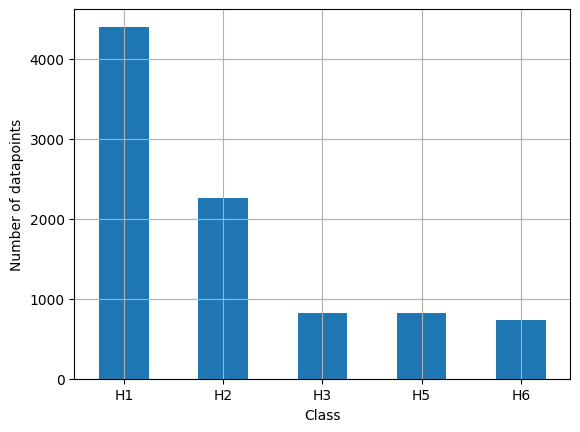

In [63]:
hist_Defungi(Defungi_data)

## Loading Images

In [64]:
# Define a function to load and preprocess an image
def load_image(image_path, label):
  # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image as JPEG
    image = tf.image.decode_jpeg(image)
    # Resize the image to project_image_size
    image = tf.image.resize(image, np.array(project_image_size))
    # Convert the image to float32 and normalize it
    image = tf.cast(image, tf.float32)
    return image, label

In [65]:
Image_List = Defungi_data_blurred['Image']
Class_List = Defungi_data_blurred['Class']

# Create a TensorFlow dataset from the image and class lists
tf_data_blurred = tf.data.Dataset.from_tensor_slices((Image_List, Class_List))

# Apply the load_image function to each element of the dataset using map
tf_data_blurred = tf_data_blurred.map(load_image, num_parallel_calls = tf.data.AUTOTUNE)
print(tf_data_blurred)

# Create batches from the datasets
tf_data_blurred = tf_data_blurred.batch(project_batch_size)

# Prefetching samples in GPU memory helps maximize GPU utilization.
tf_data_blurred = tf_data_blurred.prefetch(tf.data.AUTOTUNE)

# Print the shape of the first batch of the dataset
for image_batch, label_batch in tf_data_blurred.take(15):
    print(image_batch.shape, label_batch)


<_ParallelMapDataset element_spec=(TensorSpec(shape=(32, 32, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
(91, 32, 32, 3) tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2], shape=(91,), dtype=int64)


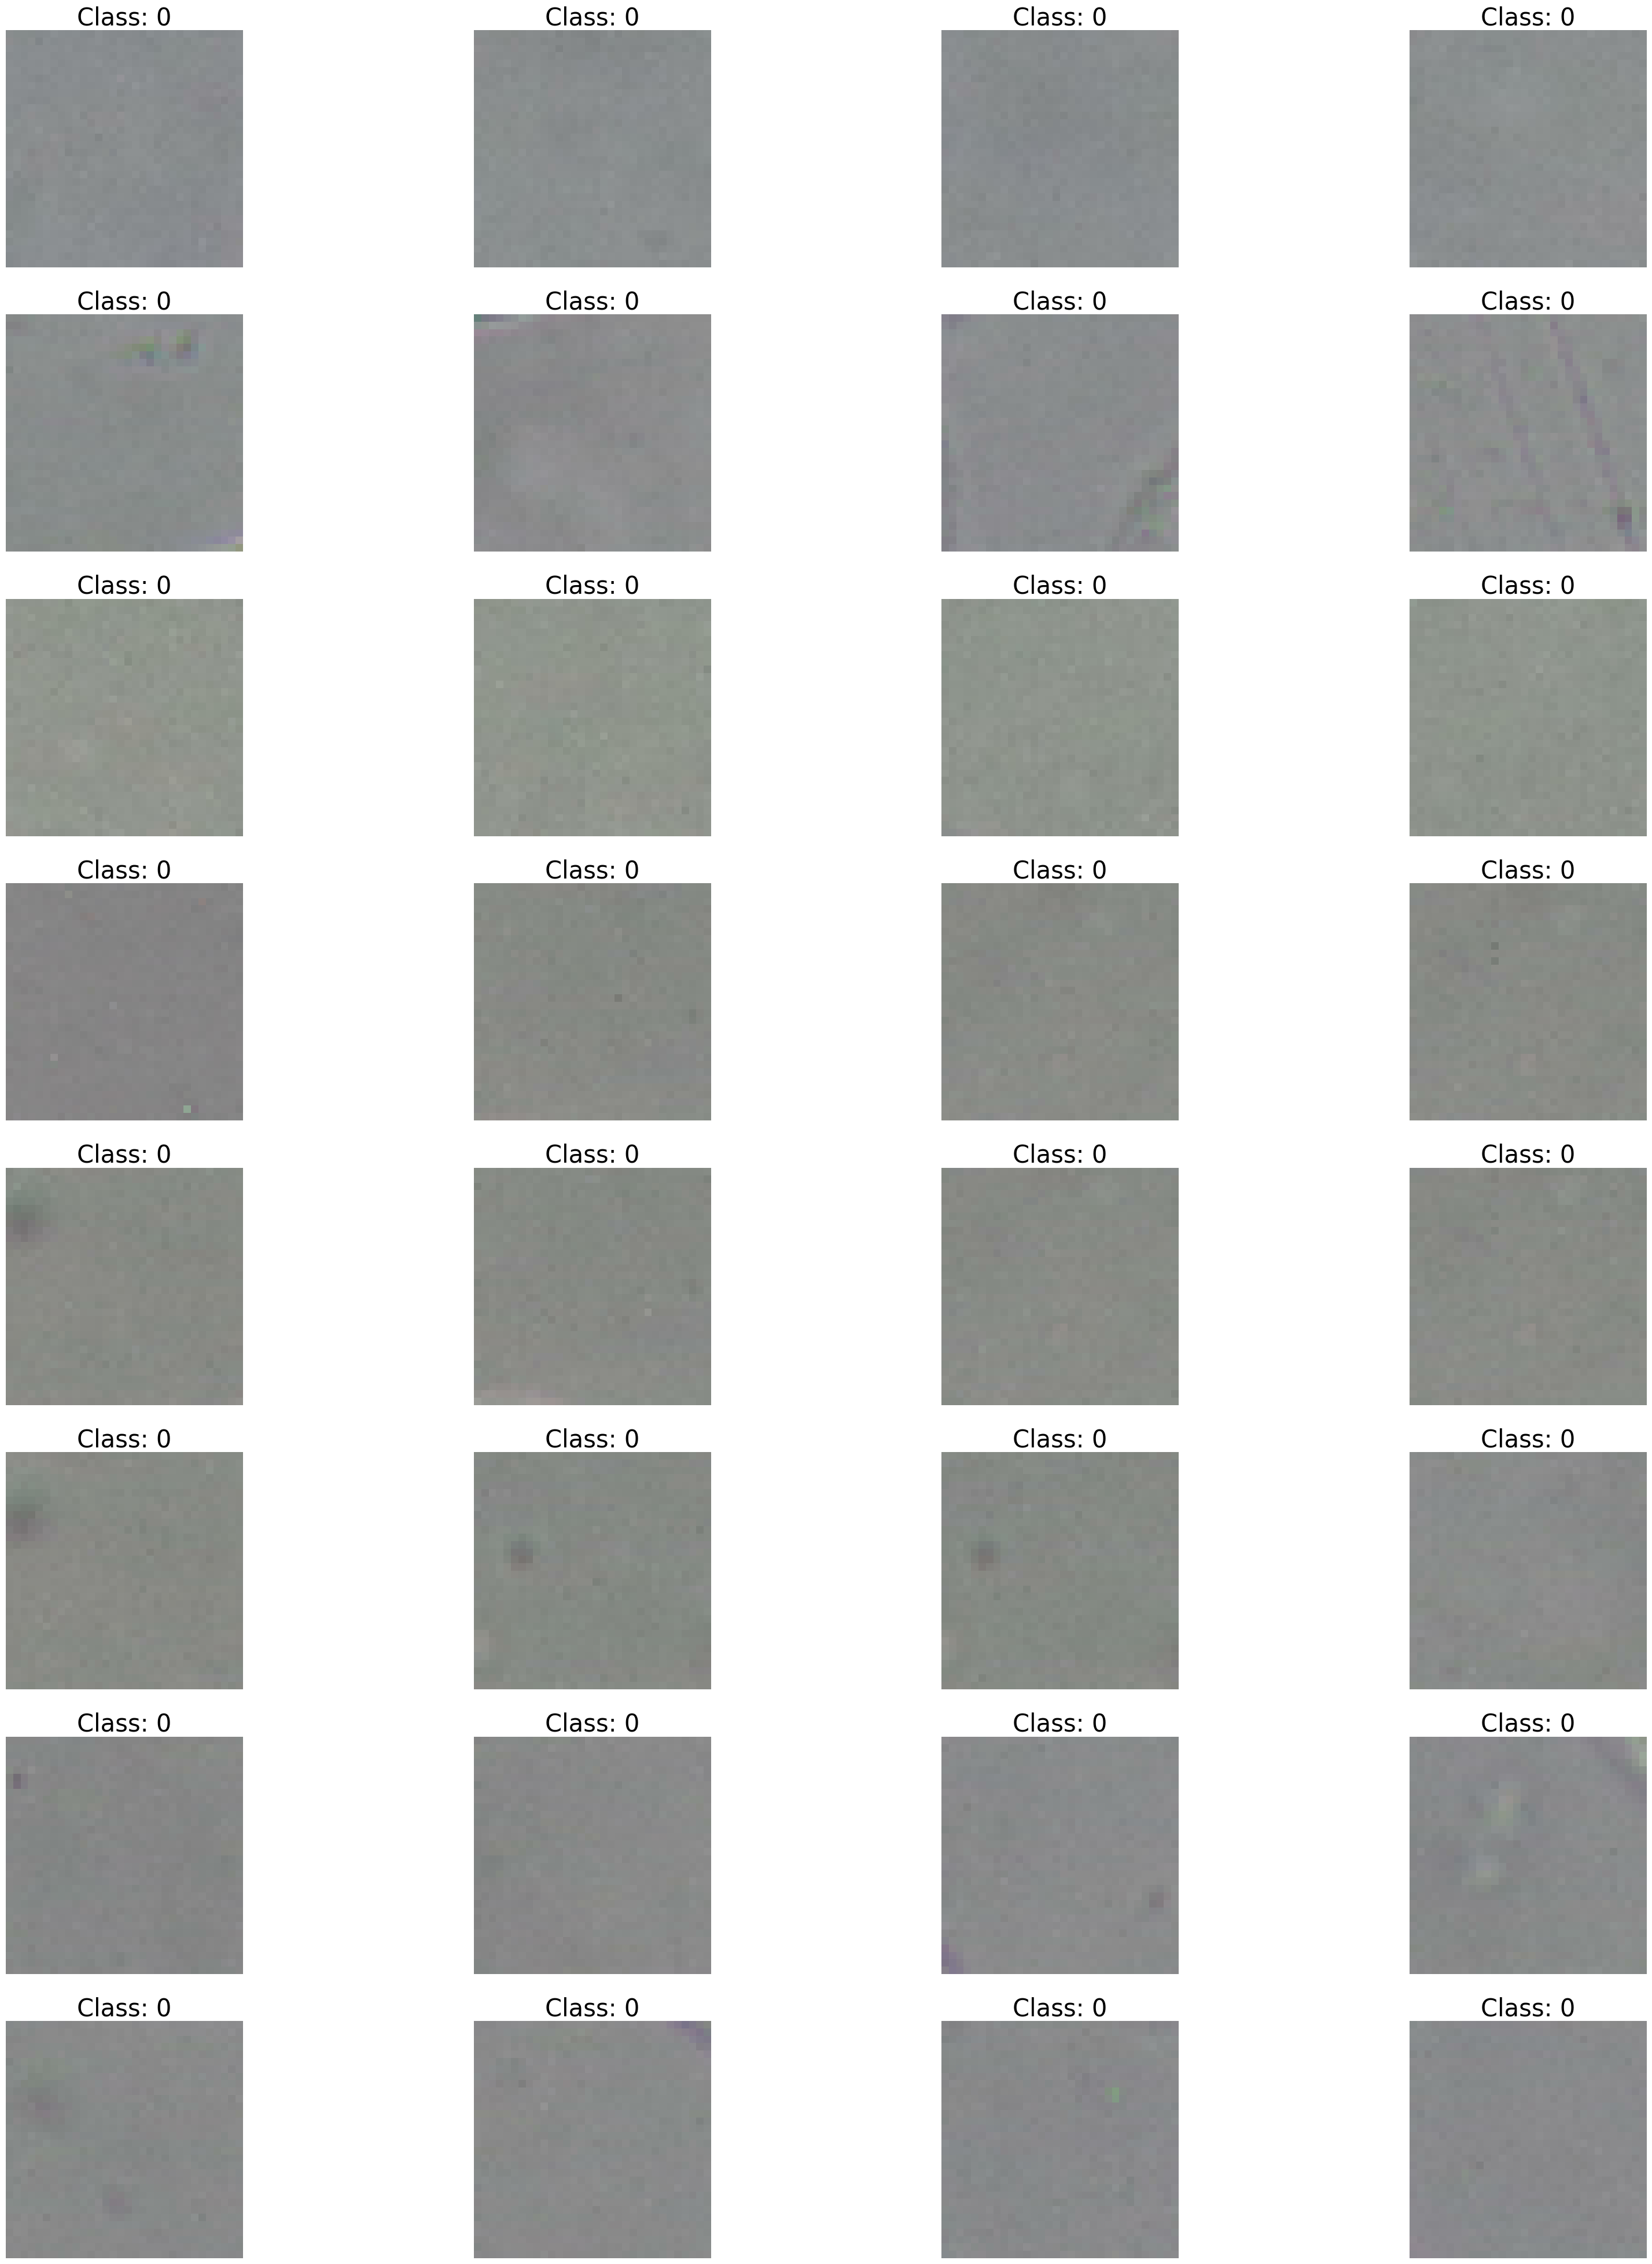

In [66]:
# Display the images
def display_images(df_display):
    data_iterator = df_display.as_numpy_iterator()
    images, labels = data_iterator.next()
    #print(len(images))
    #plt.figure(figsize = (12, 8))
    plt.figure(figsize = (40,50))
    if (len(images) > 32):
        range_for = range(32)
        row_n = 8
    else:
        range_for = range(len(images))
        row_n = round(len(images)/4)
        print(len(images))
        print(row_n)
    for i in range_for:
        plt.subplot(row_n, 4, i + 1)
        plt.imshow(images[i].astype("uint8"))
    #    plt.title(f'Class: {np.argmax(labels[i])}')
        plt.title(f'Class: {labels[i]}', fontsize = 30) 
        plt.axis('off')
    
    plt.show()

display_images(tf_data_blurred)

## Splitting Data

In [101]:
# Group the dataframe by class
Defungi_data_split = Defungi_data_clear.groupby(['Class'])

# Get the groups dictionary
groups = Defungi_data_split.groups

# Initialize the Test_data column with 0
Defungi_data_clear.loc[:,'Test_data'] = 0

# Loop over the classes
for Class in groups:
    # Get a random sample of the rows for each class
    sample = Defungi_data_clear.loc[groups[Class]].sample(frac = project_split)
    # Print the number of rows in the sample
    print(len(sample))
    # Assign 1 to the Test_data column for the sample rows
    Defungi_data_clear.loc[sample.index, 'Test_data'] = 1

print(Defungi_data_clear.groupby(['Test_data']).count())

1298
677
244
245
222
           Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  Image  Label  Class  \
Test_data                                                                
0                  6268          6268        6268   6268   6268   6268   
1                  2686          2686        2686   2686   2686   2686   

           Variance  Sobel_x  Sobel_y  Norm_Variance  Norm_Sobel_x  \
Test_data                                                            
0              6268     6268     6268           6268          6268   
1              2686     2686     2686           2686          2686   

           Norm_Sobel_y  Sobel  
Test_data                       
0                  6268   6268  
1                  2686   2686  


Label
H1    4325
H2    2257
H5     818
H3     815
H6     739
Name: count, dtype: int64


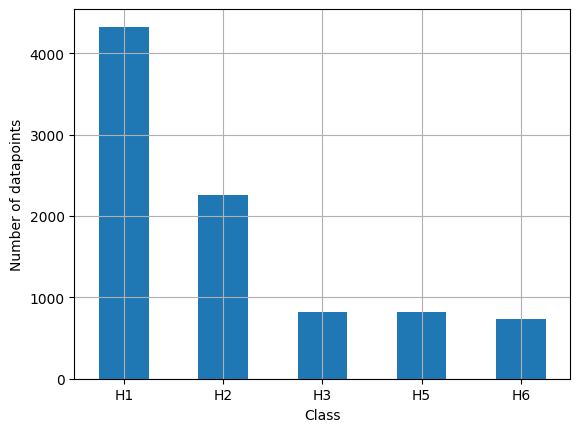

In [102]:
hist_Defungi(Defungi_data_clear)

## Applying Data Augmentation

In [103]:
import imgaug.augmenters as iaa
import numpy as np
import cv2

def augment_function(image):

    # Create a RandomRotation layer
    rotation_layer = tf.keras.layers.RandomRotation(factor = 0.5)  # Factor controls the maximum rotation angle (0.5*360)
    
    # Apply random rotation to an image (assuming 'image' is your input tensor)
    rotated_image = rotation_layer(image)
    return rotated_image
    
def load_image(image_path, label):
  # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image as JPEG
    image = tf.image.decode_jpeg(image)
    # Resize the image to project_image_size
    image = tf.image.resize(image, np.array(project_image_size))
    # Convert the image to float32 and normalize it
    image = tf.cast(image, tf.float32)
    # If not in the specified classes, return only the original image
    return image, label

In [104]:
def data_augmentation(df):
    X_df = []
    y_df = []

    for images, labels in df:
        label = labels.numpy()
        X_df.extend([images.numpy()])
        y_df.extend([labels.numpy()])
#        number_of_aug = 0
        number_of_aug = 1
        if label == 1:
#            number_of_aug = 1
            number_of_aug = 2
        elif label > 1:
            number_of_aug = 5
        for i in range(1, number_of_aug + 1):
            augmented_image = augment_function(images)
            X_df.extend([augmented_image.numpy()])
            y_df.extend([labels.numpy()])
    return X_df, y_df


In [105]:
# Create a TensorFlow dataset from the image and class lists
data_train = tf.data.Dataset.from_tensor_slices((Defungi_data_clear.loc[Defungi_data_clear['Test_data'] == 0, 'Image'],
                                                 Defungi_data_clear.loc[Defungi_data_clear['Test_data'] == 0, 'Class']))
# Apply the load_image function to each element of the dataset using map
data_train = data_train.map(load_image, num_parallel_calls = tf.data.AUTOTUNE)

X_train, y_train = data_augmentation(data_train)
data_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [106]:
data_test = tf.data.Dataset.from_tensor_slices((Defungi_data_clear.loc[Defungi_data_clear['Test_data'] == 1, 'Image'],
                                                Defungi_data_clear.loc[Defungi_data_clear['Test_data'] == 1, 'Class']))

# Apply the load_image function to each element of the dataset using map
data_test = data_test.map(load_image, num_parallel_calls = tf.data.AUTOTUNE)
print(data_test)

X_test, y_test = data_augmentation(data_test)
data_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

<_ParallelMapDataset element_spec=(TensorSpec(shape=(32, 32, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [107]:
# Shuffling and creating batches from the datasets
data_train = data_train.shuffle(buffer_size = len(X_train)).batch(project_batch_size)
data_test = data_test.shuffle(buffer_size = len(X_test)).batch(project_batch_size)

# Prefetching samples in GPU memory helps maximize GPU utilization.
data_train = data_train.prefetch(tf.data.AUTOTUNE)
data_test = data_test.prefetch(tf.data.AUTOTUNE)

# Print the shape of the first batch of the dataset
#for image_batch, image_batch1, label_batch in data_train.take(15):
for image_batch, label_batch in data_test.take(30):
    print(image_batch.shape, label_batch)

# Optional: Shuffle and batch the dataset
#data_train = data_train.shuffle(buffer_size = len(X_train_1)).batch(project_batch_size)

(128, 32, 32, 3) tf.Tensor(
[1 0 2 0 0 2 4 3 4 4 0 4 0 4 4 4 0 0 1 3 4 0 1 0 3 0 1 1 3 4 1 4 4 4 0 0 2
 0 0 1 1 0 0 1 3 2 3 4 3 1 3 4 4 1 3 0 4 4 0 0 3 3 1 1 1 2 0 0 0 0 4 4 0 3
 4 1 3 4 2 0 1 2 2 2 4 0 1 3 3 3 1 3 4 3 0 0 2 0 1 4 1 0 1 0 1 1 3 3 3 0 1
 0 0 1 1 2 2 1 0 0 0 3 4 3 0 2 4 4], shape=(128,), dtype=int32)
(128, 32, 32, 3) tf.Tensor(
[0 0 1 1 0 0 2 1 3 1 1 1 0 1 0 0 1 1 0 2 3 0 2 1 2 0 1 0 2 3 4 3 0 4 4 3 2
 1 0 2 3 2 4 4 3 1 4 2 0 1 2 1 0 4 4 0 4 1 4 1 0 4 1 2 3 0 1 4 1 1 0 1 1 1
 4 0 0 1 1 4 0 0 1 3 3 0 1 0 3 1 1 1 3 0 4 0 1 0 1 3 3 0 1 1 1 3 0 0 1 0 2
 1 4 1 1 0 4 3 4 0 1 0 2 0 0 0 0 2], shape=(128,), dtype=int32)
(128, 32, 32, 3) tf.Tensor(
[4 0 4 4 1 3 3 1 1 2 2 0 2 1 1 1 1 0 1 0 3 1 4 0 1 2 0 4 1 0 2 0 3 0 4 0 0
 2 3 0 4 0 4 3 3 2 4 1 4 0 0 1 4 1 1 2 2 3 1 0 2 4 2 2 0 1 2 0 2 3 4 0 4 1
 2 3 3 4 0 0 0 3 2 2 3 0 2 2 4 1 1 2 0 0 3 1 4 0 2 1 1 1 3 1 2 4 0 1 0 3 4
 2 4 1 0 0 1 4 3 0 4 0 1 0 2 4 2 1], shape=(128,), dtype=int32)
(128, 32, 32, 3) tf.Tensor(
[1 4 4 4 0 2 3 0 0 3 

In [108]:
X_train = []
y_train = []
X_test = []
y_test = []

for images, labels in data_train:

    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())
    
for images, labels in data_test:

    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

Element counts:
{0: 8650, 1: 6771, 2: 4890, 3: 4908, 4: 4434}


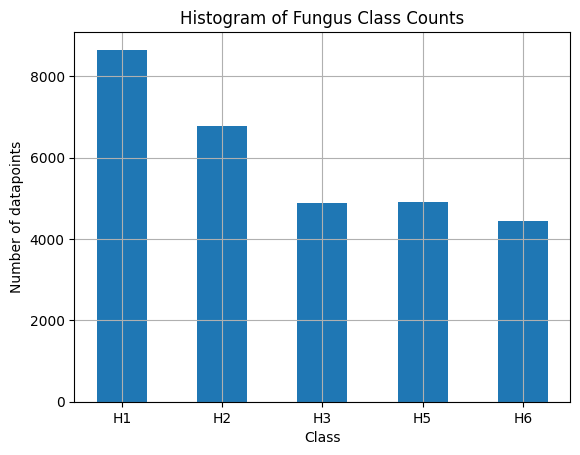

In [110]:
unique, counts = np.unique(np.concatenate((y_train, y_test)), return_counts = True)
result = dict(zip(unique, counts))
print("Element counts:")
print(result)

class_names = ['H1', 'H2', 'H3', 'H5', 'H6']

# Plot the histogram
plt.bar(class_names, result.values(), width = 0.5)
plt.xlabel('Class')
plt.xticks(class_names)
plt.ylabel('Number of datapoints')
plt.title('Histogram of Fungus Class Counts')
plt.grid(True)
plt.show()


In [111]:
print(type(X_train), " ", type(y_train))
print(len(X_train), " ", len(y_train))
print(type(y_test), " ", type(y_test))
print(len(X_test), " ", len(y_test))

<class 'list'>   <class 'list'>
20760   20760
<class 'list'>   <class 'list'>
8893   8893


## Neural Network Models

### ResNet Model

In [42]:
# Load training and testing data from the dataset using Keras
# Original images are 500x500
# ResNET-34
augmentation_layer = keras.Sequential(
    [tf.keras.layers.RandomFlip("horizontal_and_vertical"),
     tf.keras.layers.RandomRotation(factor = (-0.5, 0.5)),
    ])

def model_fungi_book(data_shape, number_of_classes, filter_size):

    inputs = keras.Input(shape = data_shape)
#    keras.regularizers.l1_l2(l1=0.01, l2=0.001)
#    x = tf.keras.layers.Rescaling(1/255.0)(inputs)
    x = augmentation_layer(inputs)
    x = tf.keras.layers.Rescaling(1/255.0)(x)
    x = tf.keras.layers.Conv2D(filters = filter_size, kernel_size = 7, strides = 2, padding = "same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = "same")(x)

    prev_filters = 64
    residual = x  # Set aside residual
        
    for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
        if filters == prev_filters:
            strides = 1
        else:
            strides = 2
        x = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = 3, strides = strides, padding = "same")(residual)
#        x = tf.keras.layers.Conv2D(filters = filters, kernel_size = 3, strides = strides, padding = "same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = 3, strides = strides, padding = "same")(x)
#        x = tf.keras.layers.Conv2D(filters = filters, kernel_size = 3, strides = strides, padding = "same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        if filters != prev_filters:
            residual = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = 1, strides = 4)(residual)
            
        x = tf.keras.layers.add([x, residual])  # Add back residual
        residual = tf.keras.layers.Activation("relu")(x)
        prev_filters = filters
            
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)

    if number_of_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = number_of_classes

    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    
    return keras.Model(inputs, outputs)

model = model_fungi_book(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 64)
model.summary()
# keras.utils.plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 32, 3)            0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 32, 32, 3)            0         ['sequential[0][0]']          
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 64)           9472      ['rescaling[0][0]']           
                                                                                              

### ConvMixer Model

In [95]:
# Load training and testing data from the dataset using Keras
# Original images are 500x500
def model_fungi_conv_mixer(data_shape, number_of_classes, dim, depth, kernel_size = 7, patch_size = 7):
    inputs = keras.Input(shape = data_shape)
    x = tf.keras.layers.Rescaling(1/255.0)(inputs)

    # Conv2D is a class that spatial convolution over images
    # filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution)
    # kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.
    # strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
    # padding: one of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input. When padding="same" and strides=1, the output has the same size as the input.
    # in https://www.kaggle.com/code/banddaniel/fungus-detect-w-10cv-custom-convmixer-f1-0-85/notebook
    # filter = 256
    x = tf.keras.layers.Conv2D(dim, kernel_size = patch_size, strides = patch_size, padding = "same")(x)
    x = tf.keras.layers.Activation("gelu")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    vector_of_ones = np.ones(depth, dtype = int)
#    print(vector_of_ones)
#    kernel_size = 2
    residual = x  # Set aside residual
#    for size in 256 * vector_of_ones:
    for _ in range(depth):
#        x = tf.keras.layers.DepthwiseConv2D(kernel_size, padding = 'same')
        x = tf.keras.layers.SeparableConv2D(dim, kernel_size, groups = dim, padding = 'same')(x)
        x = tf.keras.layers.Activation('gelu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Add()([x, residual])
        x = tf.keras.layers.SeparableConv2D(dim, kernel_size = 1)(x)
        x = tf.keras.layers.Activation('gelu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        residual = x

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    if number_of_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = number_of_classes

    outputs = tf.keras.layers.Dense(units, activation = activation)(x)
    
    return keras.Model(inputs, outputs)

model = model_fungi_conv_mixer(data_shape = project_image_size + (3,), number_of_classes = 5, 
                               dim = 256, depth = 8, kernel_size = 7, patch_size = 7)
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling_29 (Rescaling)    (None, 32, 32, 3)            0         ['input_30[0][0]']            
                                                                                                  
 conv2d_391 (Conv2D)         (None, 5, 5, 256)            37888     ['rescaling_29[0][0]']        
                                                                                                  
 activation_574 (Activation  (None, 5, 5, 256)            0         ['conv2d_391[0][0]']          
 )                                                                                         

## Learning Curve (Fitting Training/Test Split)

In [96]:
learning_rate = 0.00032
#optimizer_Adamar = Adam(learning_rate = learning_rate)
optimizer_Adamar = tf.keras.optimizers.legacy.Adam(learning_rate = learning_rate)
    
def create_model(learning_rate = learning_rate):
    optimizer_Adamar = tf.keras.optimizers.legacy.Adam(learning_rate = learning_rate)
#    model = model_fungi_book(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 64)
    model = model_fungi_conv_mixer(data_shape = project_image_size + (3,), number_of_classes = 5, 
                               dim = 256, depth = 8, kernel_size = 5, patch_size = 5)
    
    model.compile(
        optimizer = optimizer_Adamar,
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 2, name = 'top_2_acc', dtype = None)])
#        metrics = ['accuracy'])
    return model

### Learning Curve Constructed Using Validation Set Approach and Test Dataset

In [98]:
# Different train sizes (e.g., 10%, 20%, ..., 100%)
train_sizes = np.linspace(0.5, 1.0, 11)

# Convert X_train and y_train to NumPy arrays
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)
X_test_array = np.array(X_test)
y_test_array = np.array(y_test)

train_accuracy, test_accuracy = [], []
for i in train_sizes:
    sample_size = int(i * len(X_train))
    X_sample, y_sample = X_train_array[:sample_size], y_train_array[:sample_size]
    print(X_sample.shape, y_sample.shape)
    
    model_curve = create_model(learning_rate)
    history = model_curve.fit(X_sample, y_sample, epochs = 7, batch_size = project_batch_size, validation_data = (X_test_array, y_test_array))

    train_accuracy.append(history.history['accuracy'][-1])
    test_accuracy.append(history.history['val_accuracy'][-1])


(12601, 32, 32, 3) (12601,)
Epoch 1/7
99/99 [==============================] - 140s 1s/step - loss: 1.2226 - accuracy: 0.4827 - top_2_acc: 0.7586 - val_loss: 1.6101 - val_accuracy: 0.2285 - val_top_2_acc: 0.3929
Epoch 2/7
99/99 [==============================] - 116s 1s/step - loss: 0.9994 - accuracy: 0.5842 - top_2_acc: 0.8333 - val_loss: 1.6239 - val_accuracy: 0.2285 - val_top_2_acc: 0.3929
Epoch 3/7
99/99 [==============================] - 112s 1s/step - loss: 0.9028 - accuracy: 0.6224 - top_2_acc: 0.8571 - val_loss: 1.6356 - val_accuracy: 0.2285 - val_top_2_acc: 0.3929
Epoch 4/7
99/99 [==============================] - 119s 1s/step - loss: 0.8484 - accuracy: 0.6422 - top_2_acc: 0.8764 - val_loss: 1.6555 - val_accuracy: 0.2285 - val_top_2_acc: 0.3929
Epoch 5/7
99/99 [==============================] - 112s 1s/step - loss: 0.8110 - accuracy: 0.6569 - top_2_acc: 0.8829 - val_loss: 1.6602 - val_accuracy: 0.2285 - val_top_2_acc: 0.3929
Epoch 6/7
99/99 [==============================] - 1

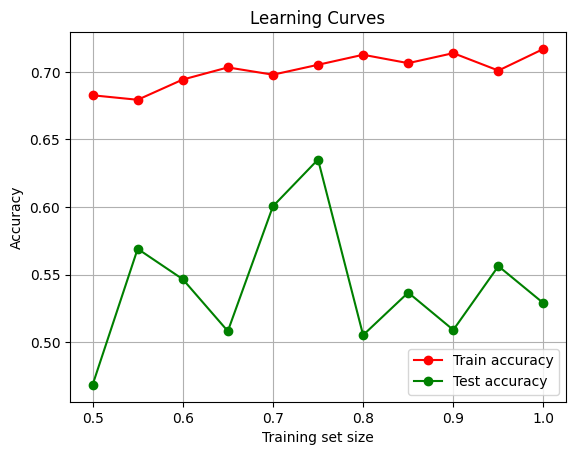

In [99]:
# Plot learning curves
#plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_accuracy, marker = 'o', linestyle = '-', color = 'r', label = 'Train accuracy')
plt.plot(train_sizes, test_accuracy, marker = 'o', linestyle = '-', color = 'g', label = 'Test accuracy')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend(loc = 4)
plt.grid(True)
plt.show()

In [197]:
print(clf)

KerasClassifier(
	model=<function create_model at 0x0000024E7F8B5AF0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=True
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)


### Learning Curve Constructed Using learning_curve function and a K-Fold Cross-Validation Approach
Only ResNet model was evaluated using K-fold cross-validation due to a high demand for calculations

In [199]:
from sklearn.model_selection import GridSearchCV

X_train = []
y_train = []
X_test = []
y_test = []

for images, labels in data_train:

    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())
    
for images, labels in data_test:

    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

## Define a Keras NN model
#def create_model(learning_rate = project_learning_rate):
#    model = model_fungi_book(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 64)
##    model = model_fungi_conv_mixer(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 256)
##    learning_rate = project_learning_rate
##    sgd = SGD(learning_rate = learning_rate)
#    Adamar = Adam(learning_rate = learning_rate)
#    #Adamar = AdamW(learning_rate = learning_rate)
#    
##    callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")]
#    
#    model.compile(
#        optimizer = Adamar,
#        loss = 'sparse_categorical_crossentropy',
#        metrics = ['accuracy'])
#    return model

# Wrap the Keras model with scikit-learn (shuffle is set to TRUE by default)
clf = KerasClassifier(model = create_model, loss = True, epochs = 8)

train_sizes, train_scores, valid_scores = learning_curve(clf, X_train, y_train, train_sizes = np.linspace(0.5, 1.00, 11),
                                                         cv = 3, scoring = 'accuracy')

Epoch 1/8
217/217 [==============================] - 31s 105ms/step - loss: 1.1831 - accuracy: 0.5067 - top_2_acc: 0.7633
Epoch 2/8
217/217 [==============================] - 22s 99ms/step - loss: 0.9747 - accuracy: 0.6051 - top_2_acc: 0.8328
Epoch 3/8
217/217 [==============================] - 26s 120ms/step - loss: 0.8817 - accuracy: 0.6439 - top_2_acc: 0.8563
Epoch 4/8
217/217 [==============================] - 24s 110ms/step - loss: 0.8243 - accuracy: 0.6664 - top_2_acc: 0.8728
Epoch 5/8
217/217 [==============================] - 24s 112ms/step - loss: 0.7938 - accuracy: 0.6726 - top_2_acc: 0.8773
Epoch 6/8
217/217 [==============================] - 25s 113ms/step - loss: 0.7741 - accuracy: 0.6773 - top_2_acc: 0.8825
Epoch 7/8
217/217 [==============================] - 22s 101ms/step - loss: 0.7625 - accuracy: 0.6939 - top_2_acc: 0.8773
Epoch 8/8
217/217 [==============================] - 8s 36ms/step
Epoch 1/8
238/238 [==============================] - 32s 100ms/step - loss: 1.163

In [288]:
print(clf)

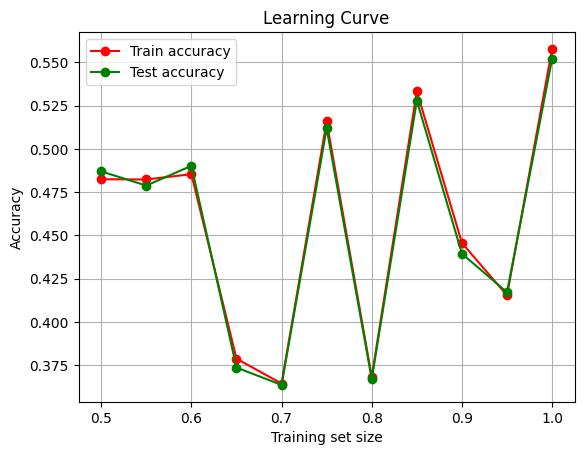

In [204]:
train_errors = train_scores.mean(axis=1)
valid_errors = valid_scores.mean(axis=1)
plt.plot(train_sizes, train_errors, marker = 'o', linestyle = '-', color = 'r', label = "Train accuracy")
plt.plot(train_sizes, valid_errors, marker = 'o', linestyle = '-', color = 'g', label = "Test accuracy")
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc = 2)
plt.grid(True)
plt.show()

## Grid Search (Fitting Hyperparameters)

In [112]:
# print(np.logspace(-4.5, -2.5, num = 5))
def print_progress(estimator):
    # Access the hyperparameters and performance metrics
    print(f"Hyperparameters: {estimator}")
#    print(f"Mean Test Score: {mean_test_score}\n")

In [118]:
from sklearn.model_selection import GridSearchCV

X_train = []
y_train = []
X_test = []
y_test = []

for images, labels in data_train:

    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())
    
for images, labels in data_test:

    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

# Define a Keras NN model
def create_model(learning_rate = project_learning_rate):
#    model = model_fungi_book(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 64)
    model = model_fungi_conv_mixer(data_shape = project_image_size + (3,), number_of_classes = 5, 
                               dim = 256, depth = 8, kernel_size = 5, patch_size = 5)
#    learning_rate = project_learning_rate
#    sgd = SGD(learning_rate = learning_rate)
    Adamar = Adam(learning_rate = learning_rate)
    #Adamar = AdamW(learning_rate = learning_rate)
    
#    callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")]
    
    model.compile(
#        optimizer = Adamar,
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy'])
    return model

# Wrap the Keras model with scikit-learn (shuffle is set to TRUE by default)
clf = KerasClassifier(model = create_model, loss = True)
scoring = {'accuracy': 'accuracy'}

# Create a pipeline with scaling and NN model
pipe = Pipeline([
    ('clf', clf) # This will fit the NN model
])

param_grid = {'epochs': [7], # Number of epochs to train the model
              'optimizer': [tf.keras.optimizers.Adam()],
# 1st evaluation (the best result is 0.001, 128
              'optimizer__learning_rate': np.logspace(-4.5, -2.5, num = 5),
#              'optimizer__learning_rate': [0.001, 0.0005, 0.0001],
#              'optimizer__learning_rate': [0.001],
# 2nd evaluation
#              'optimizer__learning_rate': [0.0005, 0.001, 0.002, 0.005],
#              'batch_size': [16, 32]
              'batch_size': [64, 128]
#              'batch_size': [128]
             }

#gs = GridSearchCV(estimator = clf, param_grid = param_grid, scoring = scoring, refit = 'accuracy', cv = 3, return_train_score = True)
gs = GridSearchCV(estimator = clf, param_grid = param_grid, scoring = scoring, refit = 'accuracy', cv = 3, n_jobs = 3, return_train_score = True)

# Fit the grid search on the training data
gs.fit(X_train, y_train)

# Print the best parameters and score
print(gs.best_params_)
print(gs.best_score_)

Epoch 1/7
325/325 [==============================] - 192s 567ms/step - loss: 1.1782 - accuracy: 0.5073
Epoch 2/7
325/325 [==============================] - 154s 474ms/step - loss: 0.8998 - accuracy: 0.6188
Epoch 3/7
325/325 [==============================] - 174s 536ms/step - loss: 0.7975 - accuracy: 0.6647
Epoch 4/7
325/325 [==============================] - 148s 456ms/step - loss: 0.7457 - accuracy: 0.6837
Epoch 5/7
325/325 [==============================] - 168s 517ms/step - loss: 0.7072 - accuracy: 0.7012
Epoch 6/7
325/325 [==============================] - 161s 496ms/step - loss: 0.6676 - accuracy: 0.7176
Epoch 7/7
325/325 [==============================] - 154s 474ms/step - loss: 0.6284 - accuracy: 0.7353
{'batch_size': 64, 'epochs': 7, 'optimizer': <keras.src.optimizers.adam.Adam object at 0x000002BD23A78A60>, 'optimizer__learning_rate': 0.001}
0.6333333333333333


In [119]:
y_pred = gs.predict(X_test)
print(gs.best_params_)
cv_res = pd.DataFrame(gs.cv_results_)
print(cv_res)

139/139 [==============================] - 15s 104ms/step
{'batch_size': 64, 'epochs': 7, 'optimizer': <keras.src.optimizers.adam.Adam object at 0x000002BD23A78A60>, 'optimizer__learning_rate': 0.001}
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0    2001.686536     17.732463        43.799111        3.736135   
1    1941.323776     33.301738        39.637712        6.807145   
2    1927.651096     52.655882        40.133380        5.882339   
3    1959.216249     21.697312        42.477595        2.757437   
4    1966.121832     41.339820        39.931869       11.638293   
5    1912.293873    262.620407        40.903565        6.066188   
6    1894.150507    238.248447        39.477773        6.626241   
7    2031.614621     61.514603        36.580331        4.975352   
8    1964.553933     94.009388        34.892871        4.966670   
9    1928.584256    128.722064        27.946381        9.071450   

  param_batch_size param_epochs  \
0               64        

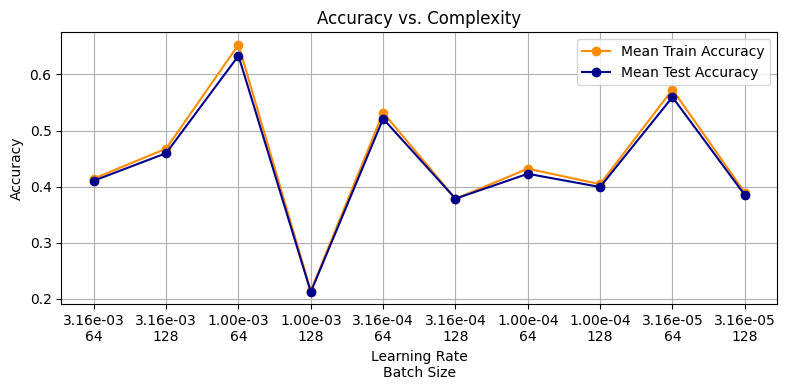

In [120]:
def plot_train_test_accuracy(cv_res):
    df_picture = []
    df_picture = cv_res[['mean_train_accuracy', 'mean_test_accuracy', 'param_batch_size', 'param_optimizer__learning_rate']].copy()
    df_picture['x_labels'] = cv_res['param_optimizer__learning_rate'].apply(lambda x: f"{x:.2e}") + '\n' + cv_res['param_batch_size'].astype(str)
    df_picture.sort_values(by = ['param_optimizer__learning_rate', 'param_batch_size'], ascending = [False, True], inplace = True)
    df_picture.reset_index(drop = True, inplace = True)
 
    # Create a figure and axis
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 4)  # Set width: 12 inches, height: 8 inches

    # Plot mean_train_accuracy
    ax.plot(df_picture.index, df_picture['mean_train_accuracy'], label = 'Mean Train Accuracy', color = 'darkorange', marker = 'o')
    
    # Plot mean_test_accuracy
    ax.plot(df_picture.index, df_picture['mean_test_accuracy'], label = 'Mean Test Accuracy', color = 'darkblue', marker = 'o')
    
    # Set x-axis labels
    ax.set_xticks(df_picture.index)
    ax.set_xticklabels(df_picture['x_labels'], rotation = 0, ha = 'center')  # Rotate labels for readability
    
    # Set labels and title
    ax.set_xlabel('Learning Rate\nBatch Size', ha = 'center')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy vs. Complexity')
    ax.grid(True)
    
    # Add legend
    ax.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

plot_train_test_accuracy(cv_res)

In [158]:
clf.set_params(**gs.best_params_)


KerasClassifier(
	model=<function create_model at 0x0000020401B62430>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.src.optimizers.adam.Adam object at 0x00000203FC45EDC0>
	loss=True
	metrics=None
	batch_size=16
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	class_weight=None
	optimizer__learning_rate=0.00031622776601683794
)

In [157]:
print(np.logspace(-4.5, -2.5, num = 5))

[3.16227766e-05 1.00000000e-04 3.16227766e-04 1.00000000e-03
 3.16227766e-03]


In [ ]:
train_errors = train_scores.mean(axis = 1)
valid_errors = valid_scores.mean(axis = 1)
plt.plot(train_sizes, train_errors, "r-+", linewidth = 2, label = "train")
plt.plot(train_sizes, valid_errors, "b-", linewidth = 3, label = "test")
plt.show()

### Final Model Compilation

#### ResNet Model Compilation

In [44]:
learning_rate = 0.00032
sgd = SGD(learning_rate = learning_rate)
Adamar = Adam(learning_rate = learning_rate)
epochs = 100

def create_model(learning_rate = project_learning_rate, optimizer = Adamar):
    model = model_fungi_book(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 64)
#    model = model_fungi_conv_mixer(data_shape = project_image_size + (3,), number_of_classes = 5, filter_size = 256)
    learning_rate = learning_rate
    
    model.compile(
        optimizer = Adamar,
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 2, name = 'top_2_acc', dtype = None)])
    return model

early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True)

model = create_model(learning_rate, Adamar)
acc_loss = model.fit(
    data_train,
    epochs = epochs,
    validation_data = data_test,
    callbacks=[early_stopping])

Epoch 1/100
1576/1576 [==============================] - 140s 80ms/step - loss: 1.0520 - accuracy: 0.5604 - top_2_acc: 0.8156 - val_loss: 1.2542 - val_accuracy: 0.4408 - val_top_2_acc: 0.6989
Epoch 2/100
1576/1576 [==============================] - 124s 78ms/step - loss: 0.8851 - accuracy: 0.6313 - top_2_acc: 0.8668 - val_loss: 1.4285 - val_accuracy: 0.3867 - val_top_2_acc: 0.6527
Epoch 3/100
1576/1576 [==============================] - 114s 72ms/step - loss: 0.8243 - accuracy: 0.6529 - top_2_acc: 0.8810 - val_loss: 0.9282 - val_accuracy: 0.5823 - val_top_2_acc: 0.8463
Epoch 4/100
1576/1576 [==============================] - 129s 82ms/step - loss: 0.7860 - accuracy: 0.6698 - top_2_acc: 0.8902 - val_loss: 1.4739 - val_accuracy: 0.4069 - val_top_2_acc: 0.6452
Epoch 5/100
1576/1576 [==============================] - 123s 78ms/step - loss: 0.7495 - accuracy: 0.6844 - top_2_acc: 0.8987 - val_loss: 1.4413 - val_accuracy: 0.4320 - val_top_2_acc: 0.6891
Epoch 6/100
1576/1576 [=================

#### ConvMixer Model Compilation

In [121]:
learning_rate = 0.001
batch_size = 64
sgd = SGD(learning_rate = learning_rate)
Adamar = Adam(learning_rate = learning_rate)
epochs = 100

def create_model(learning_rate = project_learning_rate, optimizer = Adamar):
    model = model_fungi_conv_mixer(data_shape = project_image_size + (3,), number_of_classes = 5, 
                               dim = 256, depth = 8, kernel_size = 5, patch_size = 5)
    learning_rate = learning_rate
    
    model.compile(
        optimizer = Adamar,
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 2, name = 'top_2_acc', dtype = None)])
    return model

early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True)

model = create_model(learning_rate, Adamar)
acc_loss = model.fit(
    data_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = data_test,
    callbacks=[early_stopping])

Epoch 1/100
163/163 [==============================] - 189s 1s/step - loss: 1.1641 - accuracy: 0.5048 - top_2_acc: 0.7835 - val_loss: 1.6535 - val_accuracy: 0.2284 - val_top_2_acc: 0.3930
Epoch 2/100
163/163 [==============================] - 222s 1s/step - loss: 0.9187 - accuracy: 0.6068 - top_2_acc: 0.8514 - val_loss: 1.7314 - val_accuracy: 0.2284 - val_top_2_acc: 0.5203
Epoch 3/100
163/163 [==============================] - 223s 1s/step - loss: 0.8341 - accuracy: 0.6413 - top_2_acc: 0.8763 - val_loss: 1.7054 - val_accuracy: 0.3056 - val_top_2_acc: 0.5565
Epoch 4/100
163/163 [==============================] - 227s 1s/step - loss: 0.7638 - accuracy: 0.6796 - top_2_acc: 0.8976 - val_loss: 1.5260 - val_accuracy: 0.4441 - val_top_2_acc: 0.6824
Epoch 5/100
163/163 [==============================] - 233s 1s/step - loss: 0.7261 - accuracy: 0.6915 - top_2_acc: 0.9043 - val_loss: 1.4548 - val_accuracy: 0.5394 - val_top_2_acc: 0.7792
Epoch 6/100
163/163 [==============================] - 195s 

In [127]:
learning_rate = 0.001
batch_size = 64
sgd = SGD(learning_rate = learning_rate)
Adamar = Adam(learning_rate = learning_rate)
epochs = 100

def create_model_improved(learning_rate = project_learning_rate, optimizer = Adamar):
    model_improved = model_fungi_conv_mixer(data_shape = project_image_size + (3,), number_of_classes = 5, 
                               dim = 256, depth = 16, kernel_size = 5, patch_size = 5)
    learning_rate = learning_rate
    
    model_improved.compile(
        optimizer = Adamar,
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 2, name = 'top_2_acc', dtype = None)])
    return model_improved

early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True)

model_improved = create_model_improved(learning_rate, Adamar)
acc_loss_improved = model_improved.fit(
    data_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = data_test,
    callbacks=[early_stopping])

Epoch 1/100
163/163 [==============================] - 520s 3s/step - loss: 1.2160 - accuracy: 0.4834 - top_2_acc: 0.7745 - val_loss: 1.6335 - val_accuracy: 0.2284 - val_top_2_acc: 0.3930
Epoch 2/100
163/163 [==============================] - 462s 3s/step - loss: 1.0579 - accuracy: 0.5467 - top_2_acc: 0.8304 - val_loss: 1.6704 - val_accuracy: 0.2284 - val_top_2_acc: 0.5203
Epoch 3/100
163/163 [==============================] - 457s 3s/step - loss: 0.9359 - accuracy: 0.6058 - top_2_acc: 0.8564 - val_loss: 1.8030 - val_accuracy: 0.2919 - val_top_2_acc: 0.5203
Epoch 4/100
163/163 [==============================] - 440s 3s/step - loss: 0.8703 - accuracy: 0.6267 - top_2_acc: 0.8689 - val_loss: 1.5832 - val_accuracy: 0.4037 - val_top_2_acc: 0.5873
Epoch 5/100
163/163 [==============================] - 454s 3s/step - loss: 0.8249 - accuracy: 0.6501 - top_2_acc: 0.8802 - val_loss: 3.5518 - val_accuracy: 0.3626 - val_top_2_acc: 0.4838
Epoch 6/100
163/163 [==============================] - 423s 

In [128]:
def model_performance(X_test, y_test, clf):
    X_test_np = np.array(X_test)  # Features
    y_test_np = np.array(y_test)  # Labels (integer format)

    y_pred = clf.predict(X_test_np)
    y_pred_labels = np.argmax(y_pred, axis = 1)
    
    # Confusion matrix
    print('Confusion Matrix')
    print(confusion_matrix(y_test, y_pred_labels))
    
    # Classification report includes precision,
    # recall, f1-score, and the number of actual occurrences
    print('Classification Report')
    
    # y_test
    print(classification_report(y_test, y_pred_labels))

In [129]:
model_performance(X_test, y_test, model)
model_performance(X_test, y_test, model_improved)

278/278 [==============================] - 31s 113ms/step
Confusion Matrix
[[2010  441  125   13    7]
 [ 440 1393  142   47    9]
 [ 173  177 1063   35   16]
 [  32  149    4 1284    1]
 [  43   60   23   24 1182]]
Classification Report
              precision    recall  f1-score   support

           0       0.74      0.77      0.76      2596
           1       0.63      0.69      0.66      2031
           2       0.78      0.73      0.75      1464
           3       0.92      0.87      0.89      1470
           4       0.97      0.89      0.93      1332

    accuracy                           0.78      8893
   macro avg       0.81      0.79      0.80      8893
weighted avg       0.79      0.78      0.78      8893

278/278 [==============================] - 74s 260ms/step
Confusion Matrix
[[1946  530   92   21    7]
 [ 561 1279  122   44   25]
 [ 223  176 1020   31   14]
 [  26  134   17 1286    7]
 [  35   50   41   17 1189]]
Classification Report
              precision    recall  

In [130]:
import pickle
# Save the model to disk
filename = 'ConvMixer_Balanced_dataset_improved.sav'
pickle.dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmpnfijqgrj\assets


INFO:tensorflow:Assets written to: C:\Users\olgat\AppData\Local\Temp\tmpnfijqgrj\assets
